Mesh generation using diff point distribution.


In [2]:
# General and plotting
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.tri as tri

# Random sampling and Poisson disk sampling
from scipy.stats import qmc
from scipy.spatial import Delaunay

# semiuniform sampling
import pyvista as pv
import tetgen

#Uniform sampling
import meshzoo


def plot_pyvista(nodes, simplices):
    buf = np.empty((len(simplices), 1), pv.ID_TYPE)
    buf[:] = 4
    elements = np.hstack((buf, simplices))
    elements = elements.flatten()
    cell_type = np.empty(len(simplices), dtype='uint8')
    cell_type[:] = 10

    grid = pv.UnstructuredGrid(elements, cell_type, nodes)
    #grid = tgen.grid

    # get cell centroid
    
    #esta linea es maldita
    #cambia la dimension de los elementos de 1d a 2d n,5.
    # los copia al arreglo cells y le saca primera columna que corresponde al número de vértices
    cells = grid.cells.reshape(-1, 5)[:, 1:]
    #esta wea dado los indices de los vértices de cada celda,
    #obtiene las coordenadas de los vértices y calcula su promedio
    cell_center = grid.points[cells].mean(1)

    # extract cells below the 0 xy plane
    mask = cell_center[:, 2] < 0.5
    cell_ind = mask.nonzero()[0]
    subgrid = grid.extract_cells(cell_ind)
    # advanced plotting
    plotter = pv.Plotter(notebook=True)
    plotter.background_color = 'white'
    plotter.add_mesh(subgrid, 'lightgrey', lighting=True, show_edges=True)
    plotter.add_mesh(pv.Cube(center=(0.5, 0.5, 0.5)), 'r', 'wireframe')
    #plotter.add_legend([[' Input Mesh ', 'r'], [' Tessellated Mesh ', 'black']])
    plotter.show(jupyter_backend='static')

#Move a point to the boundary of the box if the distante to the boundary is less than tolerance
def move_point(max_number, xPoint , yPoint, zPoint, tolerance):
    r =  np.random.uniform(0, 1)
    n = max_number
    # A esta wea la faltan dos casos,pero no sé me ocurren como hacerlo ahora
    if r <= 0.5:
        #if the x coord is near the extreme x coord
        if xPoint >= max_number*(1.0-tolerance): 
            xPoint = n
        #if the y coord is near the extreme y coord
        if yPoint >= max_number*(1.0-tolerance): 
            yPoint = n
        #if the z coord is near the extreme z coord
        if zPoint >= max_number*(1.0-tolerance):
            zPoint = n
        #if the x coord is near the 0-x coord
        if xPoint <= max_number*tolerance: 
            xPoint = 0
        #if the y coord is near the 0-y coord
        if yPoint <= max_number*tolerance: 
            yPoint = 0
        #if the z coord is near the 0-z coord
        if zPoint <= max_number*tolerance:
            zPoint = 0
    else:
        #if the x coord is near the 0-x coord
        if xPoint <= max_number*tolerance: 
            xPoint = 0            
        #if the y coord is near the 0-y coord
        if yPoint <= max_number*tolerance: 
            yPoint = 0
        #if the z coord is near the 0-z coord  
        if zPoint <= max_number*tolerance:
            zPoint = 0
        #if the x coord is near the extreme x coord
        if xPoint >= max_number*(1.0-tolerance): 
            xPoint = n
        #if the y coord is near the extreme y coord
        if yPoint >= max_number*(1.0-tolerance): 
            yPoint = n
        #if the z coord is near the extreme z coord
        if zPoint >= max_number*(1.0-tolerance):
            zPoint = n
        

    #print("returning", xPoint, yPoint)
    return (xPoint, yPoint, zPoint)

def add_box(arr, tolerance):
    box = [[0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1], [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]]
    arr = np.append(arr, box, axis=0)
    np.unique(arr, axis=0)
    #maxNumber = max(max(arr[:,0]), max(arr[:,1]), max(arr[:,2]))
    for i in range(0, len(arr)):
        new_p = move_point(1, arr[i,0], arr[i,1], arr[i,2], tolerance)
        arr[i,0] = new_p[0]
        arr[i,1] = new_p[1]
        arr[i,2] = new_p[2]
    return arr

In [3]:
# 500
#tolerance = 0.1 # max distance from the boundary
#numVertices = 500 #Random points
#radius = 0.105 #Poisson
#areaMax = "0.0008" #Semiuniform
#lnspace = 8 # Uniform sqrt(500)


# 1000

tolerance = 0.1 # max distance from the boundary
numVertices = 1000 #Random points
radius= 0.084 #1034
areaMax = "0.00038" #996
lnspace = 10 # Uniform sqrt(500)

# 5000

#tolerance = 0.05 # max distance from the boundary
#numVertices = 5000 #Random points
#radius= 0.049 # 5001
#areaMax = "0.0000695" # 5030
#lnspace = 17 # 4913


# 10000

#tolerance = 0.05 # max distance from the boundary
#numVertices = 10000 #Random points
#radius= 0.038 # 10175
#areaMax = "0.000033" # 10134
#lnspace = 22 # 10648


# 50000

# tolerance = 0.02 # max distance from the boundary
# numVertices = 50000 #Random points
# radius= 0.0225 #50192
# areaMax = "0.000006279" # 50027
# lnspace = 37 # 10648


## Generate random points

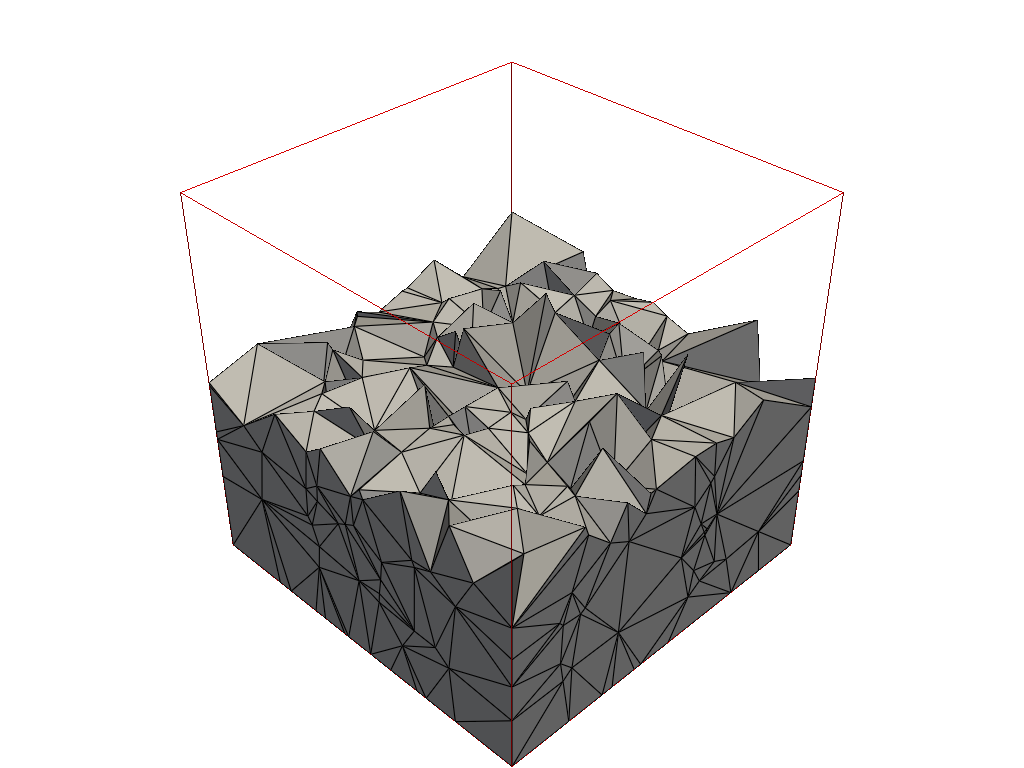

1000


In [4]:
RandomSample = np.random.rand(numVertices - 8,3)
RandomSample = add_box(RandomSample, tolerance)

randomDelaunay = Delaunay(RandomSample)

plot_pyvista(randomDelaunay.points , randomDelaunay.simplices)

print(len( randomDelaunay.points))

# Generate poisson points

Number of points:  1057


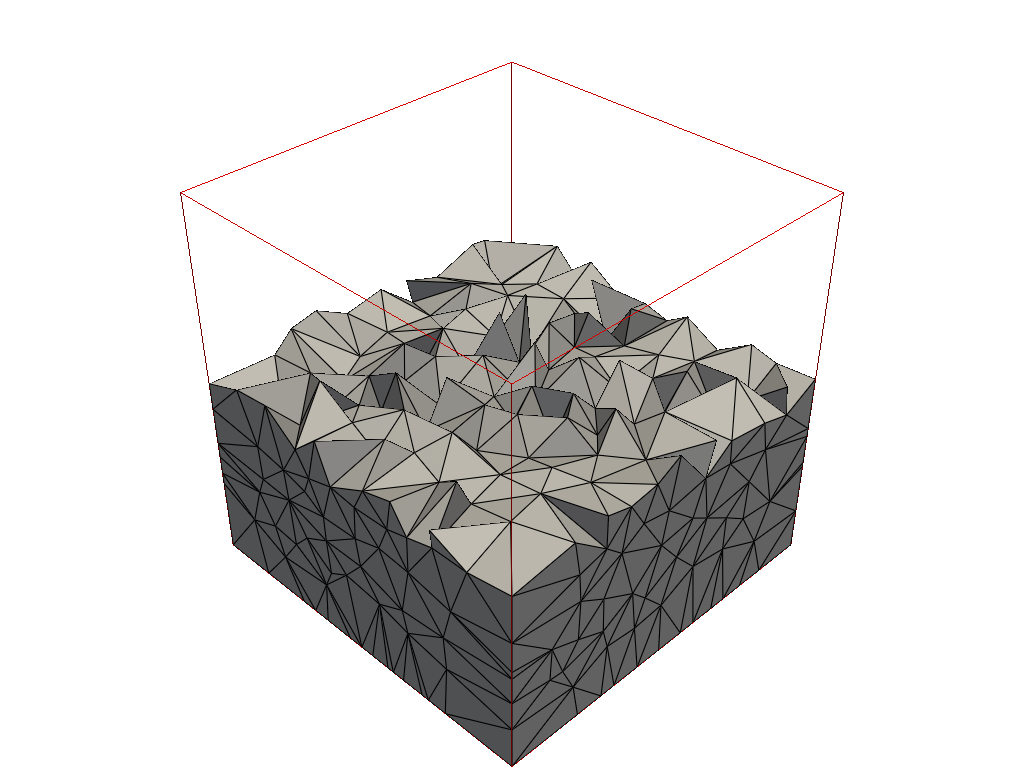

In [5]:

#radius= 0.0225 #50192

rng = np.random.default_rng()
engine = qmc.PoissonDisk(d=3, radius=radius, seed=rng)
sample = engine.fill_space()

sample = add_box(sample, tolerance)
poissonTriangulation = Delaunay(sample)

poissonPoints = sample
poissonTriangles = poissonTriangulation.simplices.copy()

print("Number of points: ", len(poissonPoints))
plot_pyvista(poissonPoints, poissonTriangulation.simplices)

## Simiuniform mesh

number of vertices:  1028


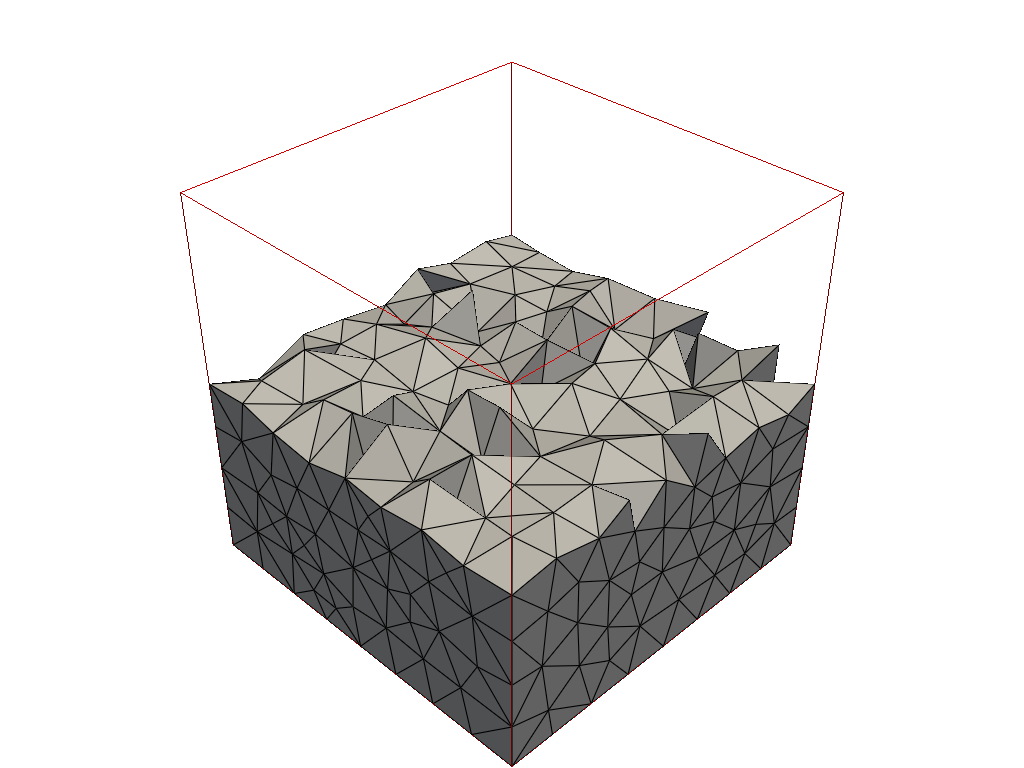

In [6]:

#areaMax = "0.000006279" # 50027

v = np.array([[0, 0, 0], [1, 0, 0],
                  [1, 1, 0], [0, 1, 0],
                  [0, 0, 1], [1, 0, 1],
                  [1, 1, 1], [0, 1, 1],])
f = np.vstack([[0, 1, 2], [2, 3, 0],
                   [0, 1, 5], [5, 4, 0],
                   [1, 2, 6], [6, 5, 1],
                   [2, 3, 7], [7, 6, 2],
                   [3, 0, 4], [4, 7, 3],
                   [4, 5, 6], [6, 7, 4]])
tgen = tetgen.TetGen(v, f)
SemiUniformPoints, SemiUniformTriangles = tgen.tetrahedralize(switches="pqa" + areaMax)

print("number of vertices: ", len(SemiUniformPoints))

plot_pyvista(SemiUniformPoints, SemiUniformTriangles)


## Uniform grid

In [7]:
#import numpy as np
#import pyvista as pv

#PointsperLine = lnspace  # The number of points per line

#PointsperLine = 5  # The number of points per line

# Generate points in 3D space

#points = np.array([[i / (PointsperLine - 1), j / (PointsperLine - 1), k / (PointsperLine - 1)]
#                   for k in range(PointsperLine)
#                   for j in range(PointsperLine)
#                   for i in range(PointsperLine)])

# Create a PyVista mesh object
#mesh = pv.PolyData(points)

# Perform a Delaunay 3D triangulation on the points

#tet_mesh = mesh.delaunay_3d(alpha=1.0)

# Extract the points and cells from the unstructured grid

#UniformPoints = tet_mesh.points
#uniformTriangles = tet_mesh.cells.reshape(-1, 5)[:, 1:]  # The first number in each row is the number of points in the cell (4 for tetrahedra)

# Now you have the vertices array and the cells array which contains the tetrahedra
# vertices - Nx3 array of the XYZ positions of the nodes
# cells - Mx4 array of the vertices that compose each tetrahedron

#plot_pyvista(UniformPoints, uniformTriangles)


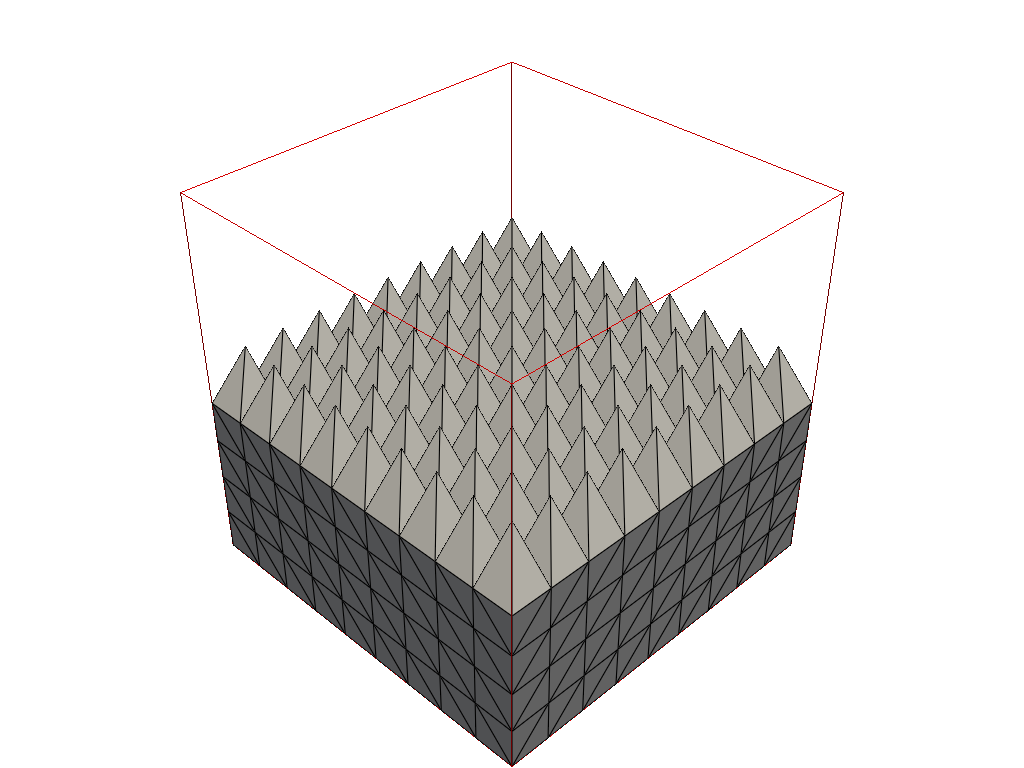

In [8]:
import pyvista as pv
import numpy as np
from vtk.util import numpy_support
from vtk import vtkTetra, vtkUnstructuredGrid, vtkCellArray

# Number of points per line
PointsperLine = lnspace  # Adjust this value as needed

# Generate points in 3D space within a unit cube
points = np.array([[i / (PointsperLine - 1), j / (PointsperLine - 1), k / (PointsperLine - 1)]
                   for k in range(PointsperLine)
                   for j in range(PointsperLine)
                   for i in range(PointsperLine)])

# Create a structured grid
grid = pv.StructuredGrid()
grid.points = points
grid.dimensions = (PointsperLine, PointsperLine, PointsperLine)

# Convert to an unstructured grid
unstructured_grid = grid.cast_to_unstructured_grid()

# Apply tetrahedralization
tetrahedralized = unstructured_grid.delaunay_3d(alpha=1.0)

# Extract nodes and tetrahedrons
UniformPoints = tetrahedralized.points
cells = tetrahedralized.cells

# Reshape cell array to extract only the indices of points in each tetrahedron
# Assuming each cell in the cell array is a tetrahedron
uniformTriangles = cells.reshape(-1, 5)[:, 1:]


# Now plot using the extracted nodes and simplices
plot_pyvista(UniformPoints, uniformTriangles)


# Generate mesh files

In [12]:
#Num of vertices and simplices
print(len(randomDelaunay.points), len(randomDelaunay.simplices))
print(len(poissonPoints), len(poissonTriangles))
print(len(SemiUniformPoints), len(SemiUniformTriangles))
print(len(UniformPoints), len(uniformTriangles))

folder = "data/"

import meshio
#writte .node files
meshio.write_points_cells(folder + str(numVertices) + "random.node", randomDelaunay.points, [("tetra", randomDelaunay.simplices)])
meshio.write_points_cells(folder + str(numVertices) + "poisson.node", poissonPoints, [("tetra", poissonTriangles)])
meshio.write_points_cells(folder + str(numVertices) + "semiuniform.node", SemiUniformPoints, [("tetra", SemiUniformTriangles)])
meshio.write_points_cells(folder + str(numVertices) + "uniform.node", UniformPoints, [("tetra", uniformTriangles)])



SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 0-1: truncated \uXXXX escape (216144089.py, line 14)

## Call to tetgen

In [10]:
import os

os.system("tetgen.exe -fzenn " + folder + str(numVertices) + "random.node")
os.system("tetgen.exe -fzenn " + folder + str(numVertices) + "poisson.node")
os.system("tetgen.exe -fzenn " + folder + str(numVertices) + "semiuniform.node")
os.system("tetgen.exe -fzenn " + folder + str(numVertices) + "uniform.node")

-1073741515